<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Traveling sales person

## Contents

In this notebook, we will learn

- How to parallelize the solution of the traveling sales person problem
- The concept of search overhead


## The traveling sales person (TSP) problem

Let us start by presenting the [traveling sales person (ASP) problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) and its solution using a [branch and bound algorithm](https://en.wikipedia.org/wiki/Branch_and_bound).

### Problem statement

- Given a graph $G$ with a distance table $C$ and an initial node (i.e. a city) in the graph
- Compute the shortest route that visits all cities exactly once, without returning to the initial city.


Note that there we consider a version of the problem in which do not return to the initial city. However, the classic version of the problem includes returning to the initial city.


As for the ASP problem we represent the distance table as a matrix, where $C_{ij}$ is the distance from node $i$ to node $j$. Next figure shows the input and solution (output) of the TSP problem for a simple 4-node graph. 

<div>
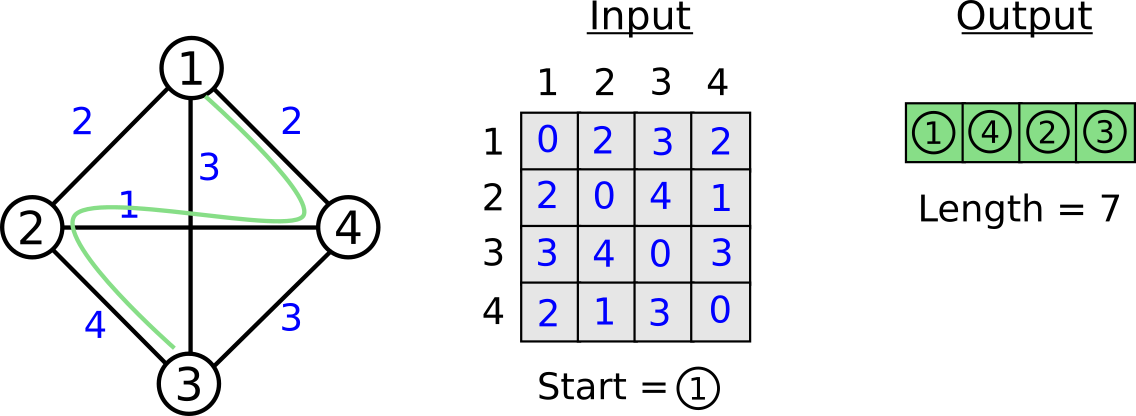
</div>
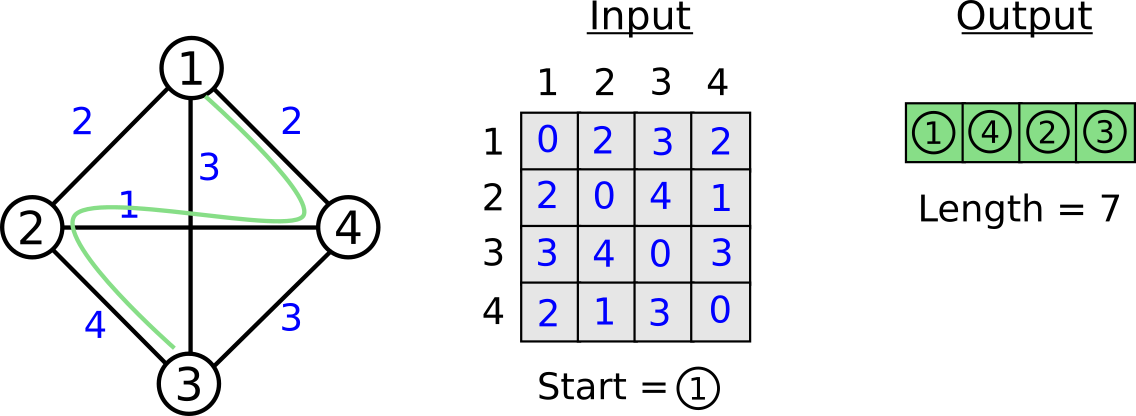

### Branch and bound algorithm





In [1]:
using Distributed

In [2]:
if procs() == workers()
    addprocs(4)
end

4-element Vector{Int64}:
 2
 3
 4
 5

In [3]:
@everywhere function visited(city,hops,path)
    for i = 1:hops
        if path[i] == city
            return true
        end
    end
    return false
end

In [4]:
function tsp_serial_impl(connections,hops,path,current_distance,min_distance)
    num_cities = length(connections)
    if hops == num_cities
        if current_distance < min_distance
            return current_distance
        end
    else
        current_city = path[hops]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections[current_city]
            if !visited(next_city,hops,path)
                path[next_hops] = next_city
                next_distance = current_distance + distance_increment
                if next_distance < min_distance
                    return tsp_serial_impl(connections,next_hops,path,next_distance,min_distance)
                end
            end
        end        
    end
    min_distance
end

tsp_serial_impl (generic function with 1 method)

In [5]:
function tsp_serial(connections,city)
    num_cities = length(connections)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    current_distance = 0
    min_distance = typemax(Int)
    min_distance = tsp_serial_impl(connections,hops,path,current_distance,min_distance)
    (;path=path,distance=min_distance)
end

tsp_serial (generic function with 1 method)

In [6]:
connections = [
    [(1,0),(4,39),(5,76), (6,78),(3,94),(2,97)],
    [(2,0),(5,25),(4,58),(3,62),(1,97),(6,109)],
    [(3,0),(6,58),(2,62),(4,68),(5,70),(1,94)],
    [(4,0),(5,38),(1,39),(2,58),(3,68),(6,78)],
    [(5,0),(2,25),(4,38),(3,70),(1,76),(6,104)],
    [(6,0),(3,58),(1,78),(4,78),(5,104),(2,109)]
]
city = 1
tsp_serial(connections,city)

(path = [1, 4, 5, 2, 3, 6], distance = 222)

In [10]:
@everywhere function tsp_dist_impl(connections,hops,path,current_distance,min_distance,max_hops,jobs_chnl,ftr_result)
    num_cities = length(connections)
    if hops == num_cities
        if current_distance < min_distance
            if ftr_result !== nothing
                @spawnat 1 begin
                    result = fetch(ftr_result)
                    result.path .= path
                    result.min_distance_ref[] = current_distance
                end |> wait
            end
            return current_distance
        end
    elseif hops <= max_hops
        current_city = path[hops]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections[current_city]
            if !visited(next_city,hops,path)
                path[next_hops] = next_city
                next_distance = current_distance + distance_increment
                if next_distance < min_distance
                    return tsp_dist_impl(connections,next_hops,path,next_distance,min_distance,max_hops,jobs_chnl,ftr_result)
                end
            end
        end 
    else
        if jobs_chnl !== nothing
            put!(jobs_chnl,(;hops,path,current_distance))
        end
    end
    min_distance
end

function tsp_dist(connections,city)
    max_hops = 2
    num_cities = length(connections)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    current_distance = 0
    min_distance = typemax(Int)
    jobs_chnl = RemoteChannel(()->Channel{Any}(10))
    ftr_result = @spawnat 1 (;path,min_distance_ref=Ref(min_distance))
    task = @async begin
        tsp_dist_impl(connections,hops,path,current_distance,min_distance,max_hops,jobs_chnl,nothing)
        for w in workers()
            put!(jobs_chnl,nothing)
        end
    end
    @sync for w in workers()
        @spawnat w begin
            max_hops = typemax(Int)
            jobs_channel = nothing
            while true
                job = take!(jobs_chnl)
                if job == nothing
                    break
                end
                hops = job.hops
                path = job.path
                current_distance = job.current_distance
                tsp_dist_impl(connections,hops,path,current_distance,min_distance,max_hops,jobs_channel,ftr_result)
            end
        end
    end 
    result = fetch(ftr_result)
    (;path = result.path, distance = result.min_distance_ref[])
end
city = 1
tsp_dist(connections,city)

(path = [1, 4, 5, 2, 3, 6], distance = 222)